In [1]:
import matplotlib.pyplot as plt
import joblib
import shap
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import xgboost as xgb

In [2]:
df_A = pd.read_csv('Final_EVSE_A.csv')
df_B = pd.read_csv('Final_EVSE_B.csv')

def prepare_categorical_output(y):
    # # Print the `y` matrix before encoding
    # print("y matrix before encoding:\n", y)

    # Convert Series to NumPy array and reshape `y` matrix
    y = y.values.reshape(-1, 1)

    # Print the `y` matrix after reshaping
    # print("y matrix after reshaping:\n", y)
    
    # One-hot encode the target variable
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(y)

    # Print the `y` matrix after one-hot encoding
    # print("y matrix after one-hot encoding:\n", y)
    
    return y

#Considering B charging station as training and A as testing

def assigning_set(df1, df2):
    # Group by 'CSVNameFile' and split the last 20% of each group into the validation set
    train_list = []
    val_list = []

    grouped = df1.groupby('CSVNameFile')

    for _, group in grouped:
        split_index = int(len(group) * 0.8)
        train_list.append(group.iloc[:split_index])
        val_list.append(group.iloc[split_index:])

    # Concatenate the training and validation sets
    train_df = pd.concat(train_list).reset_index(drop=True)
    val_df = pd.concat(val_list).reset_index(drop=True)

    # Separate features and labels for train and validation sets
    X_train = train_df.drop(columns=['CSVNameFile', 'status', 'multiclass'])
    y_train = prepare_categorical_output(train_df['multiclass'])

    X_val = val_df.drop(columns=['CSVNameFile', 'status', 'multiclass'])
    y_val = prepare_categorical_output(val_df['multiclass'])

    # X_test and y_test from df2 remain unchanged for test evaluation
    X_test = df2.drop(columns=['CSVNameFile', 'status', 'multiclass'])
    y_test = prepare_categorical_output(df2['multiclass'])

    input_dim = X_train.shape[1]
    output_dim = len(np.unique(df1['multiclass']))

    return X_train, X_val, X_test, y_train, y_val, y_test, input_dim, output_dim

X_train, X_val, X_test, y_train, y_val, y_test, input_dim, output_dim = assigning_set(df_B, df_A)

In [4]:
original_xgb_model = xgb.XGBClassifier()
original_xgb_model.load_model('xgboost_optimization.json')

In [5]:
# Get feature importances from the model
importance = original_xgb_model.feature_importances_

# Create a DataFrame for feature importances with feature names and their scores
importance_df = pd.DataFrame({
    'Feature': original_xgb_model.get_booster().feature_names,
    'Importance': importance
})

# Sort by importance and calculate the cumulative sum
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df['Cumulative Importance'] = importance_df['Importance'].cumsum()

# Display the top 10 features with cumulative importance
print(importance_df.head(10))


                       Feature  Importance  Cumulative Importance
25      src2dst_stddev_piat_ms    0.670139               0.670139
6              src2dst_packets    0.106949               0.777087
20   bidirectional_min_piat_ms    0.087958               0.865045
21  bidirectional_mean_piat_ms    0.052028               0.917073
4        bidirectional_packets    0.021417               0.938490
3    bidirectional_duration_ms    0.020947               0.959437
23   bidirectional_max_piat_ms    0.011444               0.970881
42         dst2src_ack_packets    0.007685               0.978566
43         dst2src_rst_packets    0.004037               0.982602
8              dst2src_packets    0.002253               0.984856


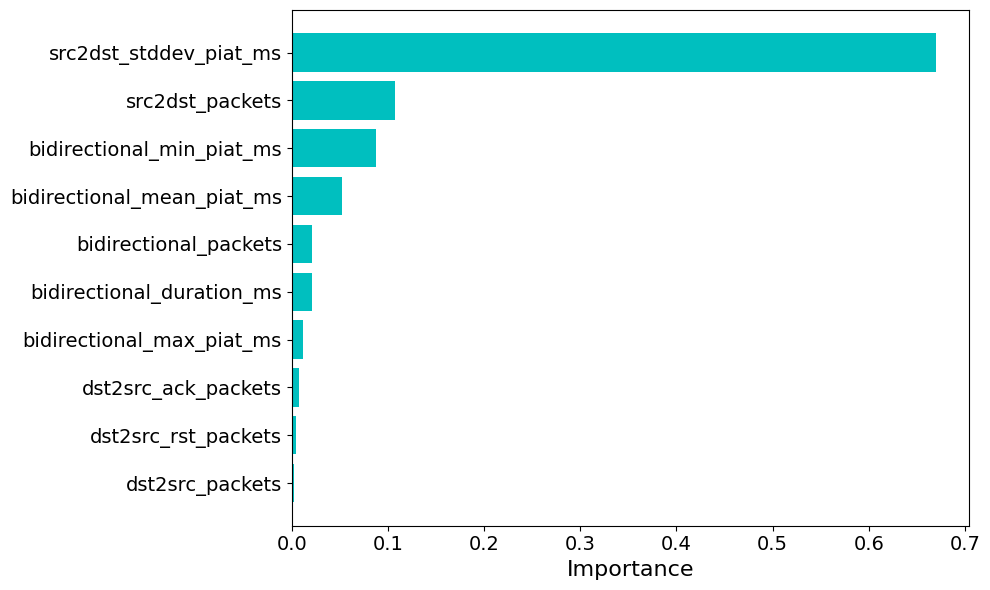

In [18]:
import matplotlib.pyplot as plt

# Select top 10 features for the plot
top_10_importance_df = importance_df.head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10_importance_df['Feature'], top_10_importance_df['Importance'], color='c')
plt.xlabel('Importance', fontsize = 16)
# plt.ylabel('Feature')
# plt.title('Top 10 Feature Importances')

# Increase fontsize for x-ticks and y-ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Invert the y-axis for better readability
plt.gca().invert_yaxis()

# Save the plot as a PDF
plt.savefig("xgb_feature_importance_plot.pdf", format="pdf", bbox_inches="tight")

# Show plot
plt.tight_layout()
plt.show()
